# Data Collection and Preparation

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [103]:
trip = pd.read_csv("cleaned_taxi_trips.csv")

## Quick look and clean trip data

### Data structure

In [4]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6495570 entries, 0 to 6495569
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip Start Timestamp        object 
 1   Trip End Timestamp          object 
 2   Trip Seconds                float64
 3   Trip Miles                  float64
 4   Pickup Census Tract         float64
 5   Dropoff Census Tract        float64
 6   Pickup Community Area       float64
 7   Dropoff Community Area      float64
 8   Fare                        float64
 9   Tips                        float64
 10  Tolls                       float64
 11  Extras                      float64
 12  Trip Total                  float64
 13  Payment Type                object 
 14  Pickup Centroid Latitude    float64
 15  Pickup Centroid Longitude   float64
 16  Dropoff Centroid Latitude   float64
 17  Dropoff Centroid Longitude  float64
dtypes: float64(15), object(3)
memory usage: 892.0+ MB


In [127]:
trip['Trip Start Timestamp'] = pd.to_datetime(trip['Trip Start Timestamp'])
trip['Trip End Timestamp'] = pd.to_datetime(trip['Trip End Timestamp'])
trip['Pickup Community Area'] = trip['Pickup Community Area'].astype('category')
trip['Dropoff Community Area'] = trip['Dropoff Community Area'].astype('category')
trip['Payment Type'] = trip['Payment Type'].astype('category')
trip['Pickup Census Tract'] = trip['Pickup Census Tract'].astype('string')
trip['Dropoff Census Tract'] = trip['Dropoff Census Tract'].astype('string')

In [107]:
trip.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,2023-01-01,2023-01-01 00:15:00,1037.000,4.820,NaN,NaN,6.000,32.000,15.750,3.250,0.000,0.000,19.500,Credit Card,41.944,-87.656,41.879,-87.625
1,2023-01-01,2023-01-01 00:15:00,1341.000,16.630,NaN,NaN,76.000,8.000,41.500,5.000,0.000,6.000,53.000,Credit Card,41.980,-87.914,41.900,-87.633
2,2023-01-01,2023-01-01 00:15:00,844.000,3.840,NaN,NaN,24.000,8.000,16.140,4.030,0.000,0.000,20.170,Mobile,41.901,-87.676,41.900,-87.633
3,2023-01-01,2023-01-01 00:00:00,361.000,0.630,NaN,NaN,32.000,32.000,5.500,0.000,0.000,1.000,6.500,Cash,41.879,-87.625,41.879,-87.625
4,2023-01-01,2023-01-01 00:15:00,704.000,0.990,NaN,NaN,14.000,14.000,7.750,0.000,0.000,0.000,7.750,Cash,41.968,-87.722,41.968,-87.722


In [109]:
trip['Trip Minutes'] = trip['Trip Seconds']/60

In [111]:
trip['Pickup Community Area'].value_counts()

Pickup Community Area
8.0     1406177
76.0    1333830
32.0    1061927
28.0     592716
33.0     237033
         ...   
9.0        1525
20.0       1198
63.0       1158
74.0       1112
18.0        607
Name: count, Length: 77, dtype: int64

In [113]:
trip['Pickup Census Tract'].value_counts()

Pickup Census Tract
17031980000.0    689680
17031320100.0    313170
17031839100.0    308288
17031281900.0    228204
17031081500.0    174565
                  ...  
17031640100.0         1
17031640700.0         1
17031838800.0         1
17031650400.0         1
17031530501.0         1
Name: count, Length: 658, dtype: int64

In [27]:
print('Count of unique centroids for dropoff:')
print(len(trip['Dropoff Centroid Latitude'].unique()))
print(len(trip['Dropoff Centroid Longitude'].unique()))

print('Count of unique centroids for pickup:')
print(len(trip['Pickup Centroid Latitude'].unique()))
print(len(trip['Pickup Centroid Longitude'].unique()))

Count of unique centroids for dropoff:
650
650
Count of unique centroids for pickup:
605
605


In [ ]:
trip['Dropoff Census Tract'].value_counts()

### Null value

In [9]:
# Calculate the percentage of null values for each column
null_percentage = trip.isnull().mean() * 100

# Display the results
print(null_percentage)

Trip Start Timestamp           0.000000
Trip End Timestamp             0.001278
Trip Seconds                   0.019783
Trip Miles                     0.000308
Pickup Census Tract           55.679271
Dropoff Census Tract          56.811211
Pickup Community Area          3.726186
Dropoff Community Area         9.538316
Fare                           0.186943
Tips                           0.186943
Tolls                          0.186943
Extras                         0.186943
Trip Total                     0.186943
Payment Type                   0.000000
Pickup Centroid Latitude       3.689407
Pickup Centroid Longitude      3.689407
Dropoff Centroid Latitude      8.928300
Dropoff Centroid Longitude     8.928300
dtype: float64


### Match Census tract - because of huge amout of missing value

In [39]:
census_tract_shapefile = gpd.read_file('Boundaries - Census Tracts - 2010-2/geo_export_9eab6027-52d4-42cd-8f49-c956f450dd88.shp')

shapefile download from Chicago data portal https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik

In [117]:
from shapely.geometry import Point
# Create GeoDataFrames for pickup and dropoff coordinates
pickup_geometry = [Point(xy) for xy in zip(trip['Pickup Centroid Longitude'], trip['Pickup Centroid Latitude'])]
dropoff_geometry = [Point(xy) for xy in zip(trip['Dropoff Centroid Longitude'], trip['Dropoff Centroid Latitude'])]

pickup_gdf = gpd.GeoDataFrame(trip, geometry=pickup_geometry, crs=census_tract_shapefile.crs)
dropoff_gdf = gpd.GeoDataFrame(trip, geometry=dropoff_geometry, crs=census_tract_shapefile.crs)

# Perform spatial joins to find the census tract for each pickup and dropoff coordinate
pickup_matched = gpd.sjoin(pickup_gdf, census_tract_shapefile, how="left", op='intersects')
dropoff_matched = gpd.sjoin(dropoff_gdf, census_tract_shapefile, how="left", op='intersects')

# Add the census tract information to the original DataFrame
trip['Pickup Census Tract 2'] = pickup_matched['geoid10']
trip['Dropoff Census Tract 2'] = dropoff_matched['geoid10']


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [149]:
trip.isnull().mean() * 100

Trip Start Timestamp          0.000
Trip End Timestamp            0.001
Trip Seconds                  0.020
Trip Miles                    0.000
Pickup Census Tract          55.679
Dropoff Census Tract         56.811
Pickup Community Area         3.726
Dropoff Community Area        9.538
Fare                          0.187
Tips                          0.187
Tolls                         0.187
Extras                        0.187
Trip Total                    0.187
Payment Type                  0.000
Pickup Centroid Latitude      3.689
Pickup Centroid Longitude     3.689
Dropoff Centroid Latitude     8.928
Dropoff Centroid Longitude    8.928
Trip Minutes                  0.020
Pickup Census Tract 2         3.726
Dropoff Census Tract 2        9.538
dtype: float64

In [129]:
trip2 = trip.dropna(subset=['Pickup Census Tract', 'Dropoff Census Tract'])

In [137]:
trip2['Pickup Census Tract'] = trip2['Pickup Census Tract'].str.split('.').str[0]
trip2['Dropoff Census Tract'] = trip2['Dropoff Census Tract'].str.split('.').str[0]

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1193/4068127607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip2['Pickup Census Tract'] = trip2['Pickup Census Tract'].str.split('.').str[0]
/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1193/4068127607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip2['Dropoff Census Tract'] = trip2['Dropoff Census Tract'].str.split('.').str[0]


In [155]:
trip2[(trip2['Pickup Census Tract']!=trip2['Pickup Census Tract 2'])*(trip2['Pickup Census Tract 2'].isna()==False)]

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1193/2243072991.py:1: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  trip2[(trip2['Pickup Census Tract']!=trip2['Pickup Census Tract 2'])*(trip2['Pickup Census Tract 2'].isna()==False)]


,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Extras,Trip Total,Payment Type,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Trip Minutes,Pickup Census Tract 2,Dropoff Census Tract 2


In [165]:
trip[(trip['Pickup Census Tract'].isna())*(trip['Pickup Census Tract 2'].isna())]

/var/folders/q0/28sgftpx7mb30vnjx_c6m9gc0000gn/T/ipykernel_1193/718806973.py:1: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  trip[(trip['Pickup Census Tract'].isna())*(trip['Pickup Census Tract 2'].isna())]


,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Trip Minutes,Pickup Census Tract 2,Dropoff Census Tract 2,Pickup Tract Combined,Dropoff Tract Combined
15,2023-01-01 00:00:00,2023-01-01 00:00:00,6.000,0.070,<NA>,<NA>,NaN,NaN,3.250,0.000,...,Cash,NaN,NaN,NaN,NaN,0.100,NaN,NaN,<NA>,<NA>
44,2023-01-01 00:00:00,2023-01-01 00:45:00,1817.000,17.840,<NA>,17031320100.0,NaN,32.000,45.000,10.100,...,Credit Card,NaN,NaN,41.885,-87.621,30.283,NaN,17031320100,<NA>,17031320100.0
75,2023-01-01 00:00:00,2023-01-01 00:00:00,6.000,0.070,<NA>,<NA>,NaN,NaN,3.250,0.000,...,Cash,NaN,NaN,NaN,NaN,0.100,NaN,NaN,<NA>,<NA>
81,2023-01-01 00:00:00,2023-01-01 00:15:00,660.000,0.000,<NA>,<NA>,NaN,NaN,15.200,0.000,...,Credit Card,NaN,NaN,NaN,NaN,11.000,NaN,NaN,<NA>,<NA>
89,2023-01-01 00:00:00,2023-01-01 00:30:00,1198.000,8.900,<NA>,<NA>,NaN,NaN,24.250,7.720,...,Credit Card,NaN,NaN,NaN,NaN,19.967,NaN,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495305,2023-12-31 23:15:00,2023-12-31 23:30:00,559.000,2.590,<NA>,<NA>,NaN,2.000,9.630,2.020,...,Mobile,NaN,NaN,42.002,-87.695,9.317,NaN,17031020602,<NA>,17031020602
6495388,2023-12-31 23:30:00,2023-12-31 23:30:00,306.000,1.650,<NA>,<NA>,NaN,NaN,9.000,2.810,...,Mobile,NaN,NaN,NaN,NaN,5.100,NaN,NaN,<NA>,<NA>
6495449,2023-12-31 23:30:00,2023-12-31 23:45:00,720.000,0.400,<NA>,<NA>,NaN,NaN,7.500,0.000,...,Cash,NaN,NaN,NaN,NaN,12.000,NaN,NaN,<NA>,<NA>
6495496,2023-12-31 23:45:00,2024-01-01 00:15:00,1280.000,8.190,<NA>,<NA>,NaN,NaN,22.500,3.000,...,Credit Card,NaN,NaN,NaN,NaN,21.333,NaN,NaN,<NA>,<NA>


In [139]:
trip2.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Extras,Trip Total,Payment Type,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Trip Minutes,Pickup Census Tract 2,Dropoff Census Tract 2
34,2023-01-01,2023-01-01 00:15:00,507.000,0.520,17031081700,17031081500,8.000,8.000,6.000,0.000,...,1.500,7.500,Cash,41.892,-87.632,41.893,-87.626,8.450,17031081700,17031081500
41,2023-01-01,2023-01-01 00:15:00,1341.000,16.630,17031980000,17031081500,76.000,8.000,41.500,5.000,...,6.000,53.000,Credit Card,41.979,-87.903,41.893,-87.626,22.350,17031980000,17031081500
52,2023-01-01,2023-01-01 00:00:00,384.000,0.480,17031081500,17031081403,8.000,8.000,5.500,2.000,...,0.000,8.000,Credit Card,41.893,-87.626,41.891,-87.619,6.400,17031081500,17031081403
54,2023-01-01,2023-01-01 00:30:00,1764.000,15.460,17031980000,17031071500,76.000,7.000,41.500,0.000,...,8.000,49.500,Cash,41.979,-87.903,41.915,-87.632,29.400,17031980000,17031071500
55,2023-01-01,2023-01-01 00:15:00,734.000,0.870,17031839100,17031081700,32.000,8.000,7.750,0.000,...,0.000,7.750,Cash,41.881,-87.633,41.892,-87.632,12.233,17031839100,17031081700


In [159]:
trip['Pickup Tract Combined'] = trip['Pickup Census Tract'].fillna(trip['Pickup Census Tract 2'])
trip['Dropoff Tract Combined'] = trip['Dropoff Census Tract'].fillna(trip['Dropoff Census Tract 2'])

In [161]:
trip.isnull().mean() * 100

Trip Start Timestamp          0.000
Trip End Timestamp            0.001
Trip Seconds                  0.020
Trip Miles                    0.000
Pickup Census Tract          55.679
Dropoff Census Tract         56.811
Pickup Community Area         3.726
Dropoff Community Area        9.538
Fare                          0.187
Tips                          0.187
Tolls                         0.187
Extras                        0.187
Trip Total                    0.187
Payment Type                  0.000
Pickup Centroid Latitude      3.689
Pickup Centroid Longitude     3.689
Dropoff Centroid Latitude     8.928
Dropoff Centroid Longitude    8.928
Trip Minutes                  0.020
Pickup Census Tract 2         3.726
Dropoff Census Tract 2        9.538
Pickup Tract Combined         3.677
Dropoff Tract Combined        8.816
dtype: float64

In [9]:
trip = trip.dropna() ### I drop all rows with null here for now, 
### but we can also try to match the missing value for other columns(e.g. mean value).

## Link other data

### Weather data

In [10]:
from meteostat import Point, Hourly
from datetime import datetime, timedelta

# # Define a function to fetch weather data for a given point and time
# def fetch_weather_data(lat, lon, start, end):
#     point = Point(lat, lon)
#     weather_data = Hourly(point, start, end)
#     weather_data = weather_data.fetch()
#     return weather_data

In [11]:
# # Extend the fetch_weather_data function to get hourly data for a range of dates
# weather_dfs = []

# # Unique combinations of latitude, longitude, and datetime in the trip data
# unique_locations = trip[['Pickup Centroid Latitude', 'Pickup Centroid Longitude']].drop_duplicates()
# dates = trip['Trip Start Timestamp'].dt.floor('D').drop_duplicates()

# # Fetch weather data for each unique location and date
# for date in dates:
#     start = datetime(date.year, date.month, date.day, 0, 0)
#     end = start + timedelta(days=1)
#     for _, row in unique_locations.iterrows():
#         lat, lon = row['Pickup Centroid Latitude'], row['Pickup Centroid Longitude']
#         weather_data = fetch_weather_data(lat, lon, start, end)
#         weather_data.reset_index(inplace=True)
#         weather_data['Pickup Centroid Latitude'] = lat
#         weather_data['Pickup Centroid Longitude'] = lon
#         weather_dfs.append(weather_data)

# # Combine all weather data into a single DataFrame
# all_weather_df = pd.concat(weather_dfs)

# # Merge with the trip data on the timestamp and location
# trip['Trip Start Timestamp'] = trip['Trip Start Timestamp'].dt.floor('H')
# all_weather_df['time'] = all_weather_df['time'].dt.floor('H')
# merged_df = pd.merge(trip, all_weather_df, left_on=['Trip Start Timestamp', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude'],
#                      right_on=['time', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude'])

# print(merged_df)


Since it take forever, we match the hourly weather data with the center of all latitude and longitude(more point have more weight)

In [12]:
# Calculate the average latitude and longitude for the center
center_lat = trip['Pickup Centroid Latitude'].mean()
center_lon = trip['Pickup Centroid Longitude'].mean()
print(f"Center of pickup trip in Chicago (Average Coordinates): Latitude {center_lat}, Longitude {center_lon}")

Center of pickup trip in Chicago (Average Coordinates): Latitude 41.89907495172692, Longitude -87.69003557726059


In [13]:
# Define the location using Point
location = Point(center_lat, center_lon)

# Define the date range for 2023
start = datetime(2023, 1, 1)
end = datetime(2023, 12, 31)

# Fetch hourly data
data = Hourly(location, start, end)
data = data.fetch()
data.reset_index(inplace=True)

In [14]:
data.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2023-01-01 00:00:00,2.0,-1.3,79.0,0.0,NaN,121.0,6.0,NaN,1013.0,NaN,3.0
1,2023-01-01 01:00:00,2.2,-1.1,79.0,0.0,NaN,140.0,5.4,NaN,1013.8,NaN,3.0
2,2023-01-01 02:00:00,2.8,-1.0,76.0,0.0,NaN,140.0,14.8,NaN,1013.2,NaN,3.0
3,2023-01-01 03:00:00,2.8,0.0,82.0,0.0,NaN,0.0,0.0,NaN,1012.9,NaN,3.0
4,2023-01-01 04:00:00,2.8,0.0,82.0,0.0,NaN,0.0,0.0,NaN,1012.9,NaN,12.0


In [15]:
# Merge trip data with weather data on date and hour
trip['Date'] = trip['Trip Start Timestamp'].dt.date
trip['Hour'] = trip['Trip Start Timestamp'].dt.hour
data['Date'] = pd.to_datetime(data['time']).dt.date
data['Hour'] = pd.to_datetime(data['time']).dt.hour

trip = pd.merge(trip, data, on=['Date', 'Hour'], how='left')

# Print or further process the merged DataFrame
trip.drop(['time'], axis=1, inplace=True)

In [16]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5774730 entries, 0 to 5774729
Data columns (total 31 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip Start Timestamp        datetime64[ns]
 1   Trip End Timestamp          datetime64[ns]
 2   Trip Seconds                float64       
 3   Trip Miles                  float64       
 4   Pickup Census Tract         object        
 5   Dropoff Census Tract        object        
 6   Pickup Community Area       category      
 7   Dropoff Community Area      category      
 8   Fare                        float64       
 9   Tips                        float64       
 10  Tolls                       float64       
 11  Extras                      float64       
 12  Trip Total                  float64       
 13  Payment Type                category      
 14  Pickup Centroid Latitude    float64       
 15  Pickup Centroid Longitude   float64       
 16  Dropoff Centroid L

### Point of Interest(Basketball, baseball game, special event...)

## Data Description

### Numerical variable

In [34]:
trip.drop(['Trip Start Timestamp','Trip End Timestamp','Dropoff Census Tract', 'Pickup Census Tract'], axis=1).describe().map(lambda x: f"{x:0.3f}").transpose()

,count,mean,std,min,25%,50%,75%,max
Trip Seconds,6494285.000,1243.561,1712.881,0.000,479.000,925.000,1734.000,86382.000
Trip Miles,6495550.000,6.514,7.630,0.000,0.920,2.900,11.700,1132.360
Fare,6483427.000,22.253,22.063,0.000,8.250,15.000,34.720,9999.750
Tips,6483427.000,2.977,4.277,0.000,0.000,1.270,4.210,500.000
Tolls,6483427.000,0.059,12.752,0.000,0.000,0.000,0.000,6666.660
Extras,6483427.000,2.281,20.953,0.000,0.000,0.000,4.000,9693.780
Trip Total,6483427.000,27.741,38.801,0.000,10.250,18.400,43.500,9999.750
Pickup Centroid Latitude,6255922.000,41.902,0.063,41.650,41.879,41.895,41.968,42.021
Pickup Centroid Longitude,6255922.000,-87.701,0.113,-87.914,-87.751,-87.643,-87.625,-87.531
Dropoff Centroid Latitude,5915626.000,41.894,0.057,41.660,41.879,41.892,41.923,42.021


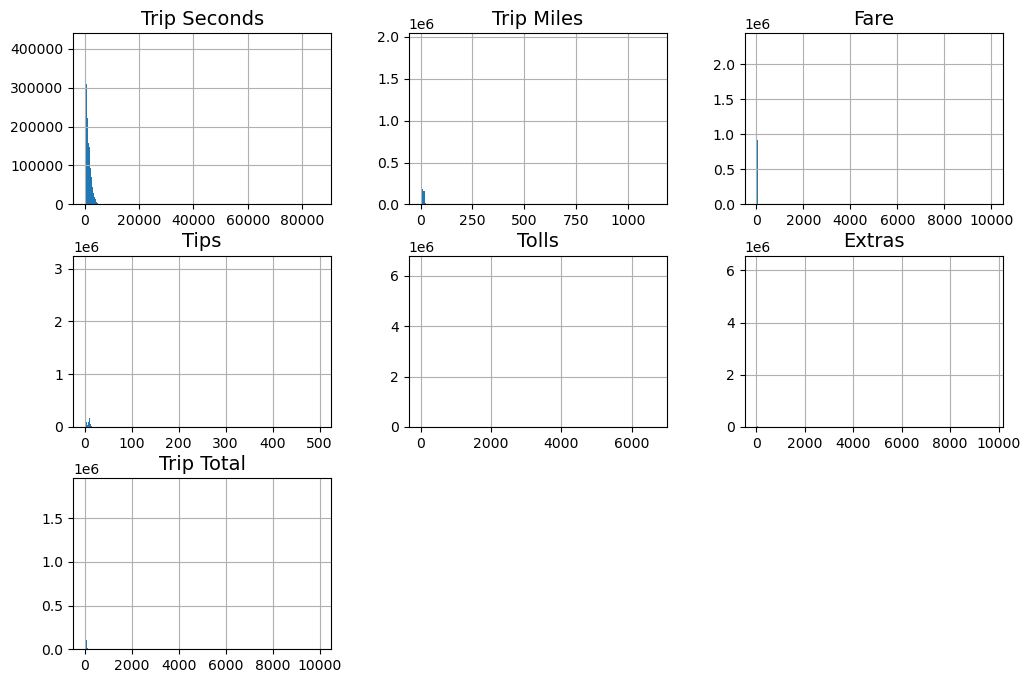

In [17]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

trip[["Trip Seconds","Trip Miles","Fare","Tips","Tolls","Extras","Trip Total"]].hist(bins=1000, figsize=(12, 8))
plt.show()

### Categorical variable

In [51]:
cross_tab = pd.crosstab(trip['Trip Start Timestamp'].dt.dayofweek, trip['Trip Start Timestamp'].dt.hour)

<Axes: xlabel='Trip Start Timestamp', ylabel='Trip Start Timestamp'>

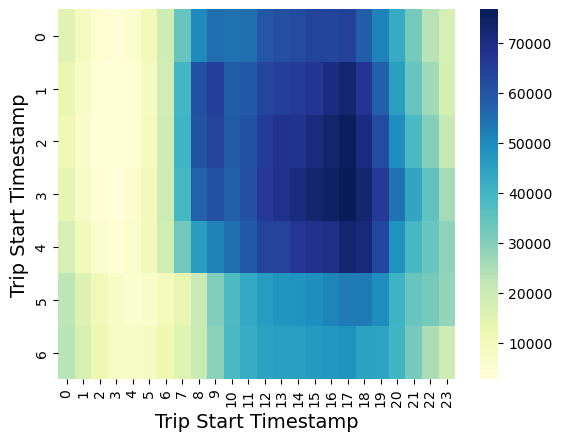

In [63]:
sns.heatmap(cross_tab, cmap='YlGnBu', annot=False, fmt='d')

In [57]:
cross_tab2 = pd.crosstab(trip['Trip End Timestamp'].dt.dayofweek, trip['Trip End Timestamp'].dt.hour)

<Axes: xlabel='Trip End Timestamp', ylabel='Trip End Timestamp'>

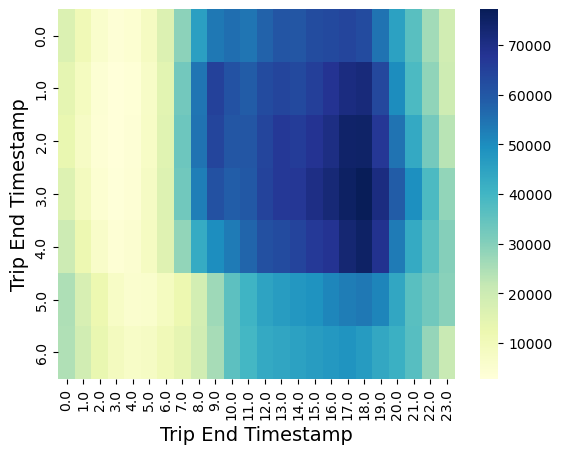

In [61]:
sns.heatmap(cross_tab2, cmap='YlGnBu', annot=False, fmt='d')

### Pickup/ Dropoff location(randomly select one day)

Shapefile download from Chicago data portal: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

In [18]:
chicago_shapefile = gpd.read_file('Boundaries - Community Areas/geo_export_565f752c-7a2a-4e11-b8e1-72c1b17e47fb.shp')


#### Pickup location




In [19]:
pickup = trip.copy()
pickup['Trip Start Timestamp'] = pd.to_datetime(pickup['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
trip_start_dates = pickup['Trip Start Timestamp'].dt.date

np.random.seed(42)
random_day = np.random.choice(trip_start_dates.unique())
filtered_df = pickup[pickup['Trip Start Timestamp'].dt.date == random_day]

pickup = filtered_df[['Pickup Centroid Latitude', 'Pickup Centroid Longitude','Trip Start Timestamp']]
pickup.reset_index(drop=True, inplace=True)

In [20]:
pickup.head()

,Pickup Centroid Latitude,Pickup Centroid Longitude,Trip Start Timestamp
0,41.980264,-87.913625,2023-04-13
1,41.874005,-87.663518,2023-04-13
2,41.874005,-87.663518,2023-04-13
3,41.980264,-87.913625,2023-04-13
4,41.979071,-87.903040,2023-04-13


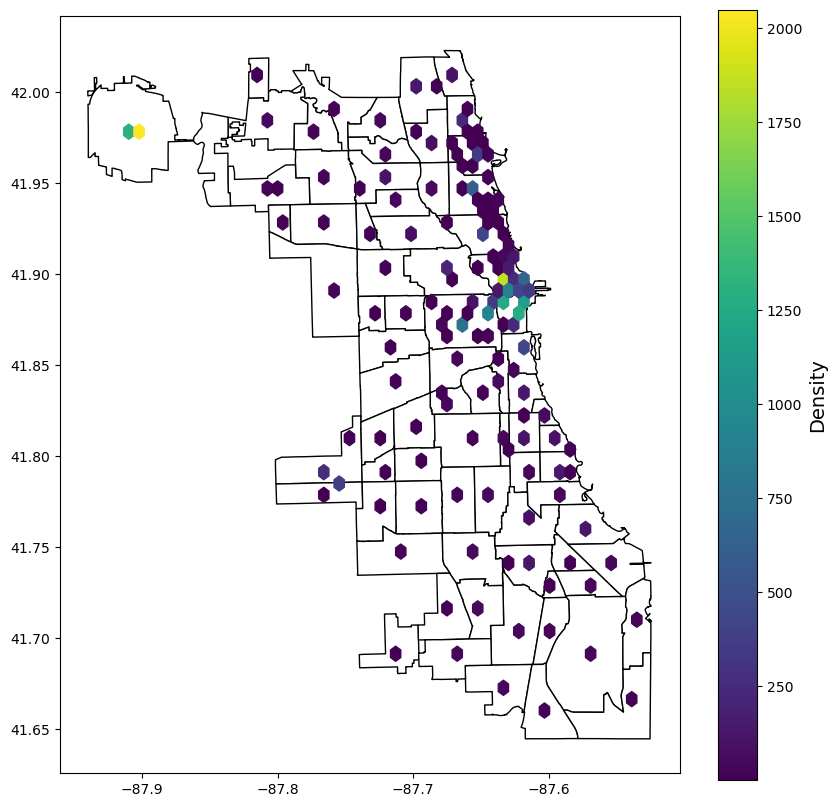

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
chicago_shapefile.plot(ax=ax, color='white', edgecolor='black')

# Create a hexbin plot to show the density of pickup points
hb = ax.hexbin(pickup["Pickup Centroid Longitude"], pickup["Pickup Centroid Latitude"], gridsize=50, cmap='viridis', mincnt=1)

# Add a color bar to indicate the density
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Density')

plt.show()

#### Dropoff location

In [22]:
dropoff = filtered_df[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude','Trip Start Timestamp']]
dropoff.reset_index(drop=True, inplace=True)

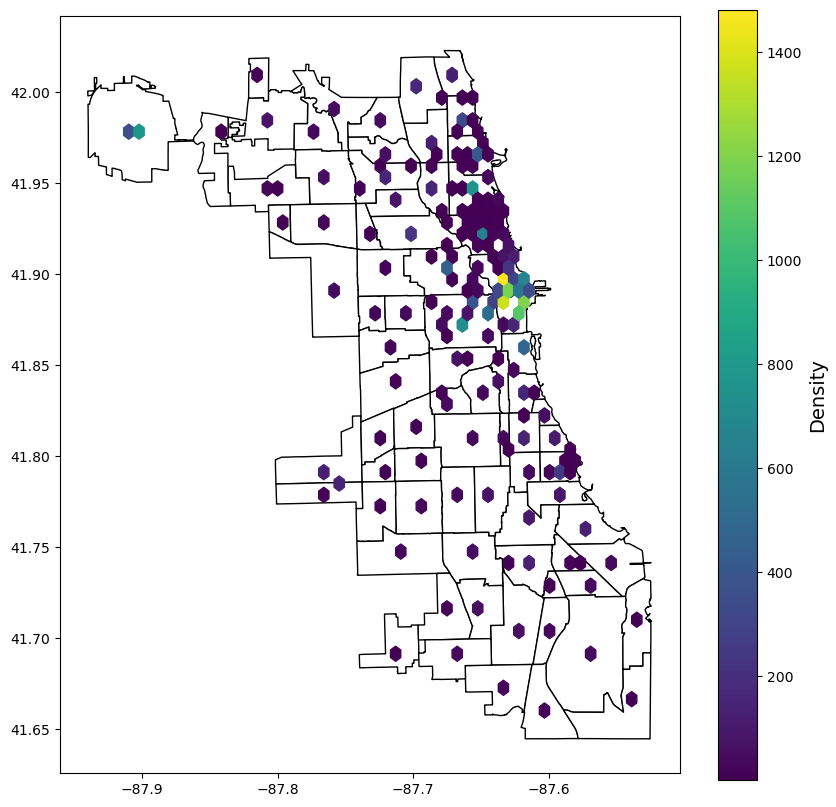

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
chicago_shapefile.plot(ax=ax, color='white', edgecolor='black')

# Create a hexbin plot to show the density of pickup points
hb = ax.hexbin(dropoff["Dropoff Centroid Longitude"], dropoff["Dropoff Centroid Latitude"], gridsize=50, cmap='viridis', mincnt=1)

# Add a color bar to indicate the density
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Density')

plt.show()

# Spatial Analysis

In [169]:
pd.crosstab(trip['Pickup Tract Combined'], trip['Dropoff Tract Combined'])

Dropoff Tract Combined,17031010100.0,17031010201.0,17031010202.0,17031010300.0,17031010400.0,17031010501.0,17031010502.0,17031010503.0,17031010600.0,17031010701.0,...,17031843200,17031843200.0,17031843300.0,17031843500.0,17031843600.0,17031843700.0,17031843900.0,17031980000,17031980000.0,17031980100.0
Pickup Tract Combined,,,,,,,,,,,,,,,,,,,,,
17031010100.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17031010201.0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17031010202.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
17031010300.0,0,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17031010400.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17031843700.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,0
17031843900.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
17031980000,0,0,0,0,0,0,0,0,0,0,...,2120,0,0,0,0,0,0,22778,0,0


In [179]:
sum(trip['Pickup Tract Combined'].fillna('0')==trip['Dropoff Tract Combined'].fillna('A'))/len(trip)

0.12225162687801071

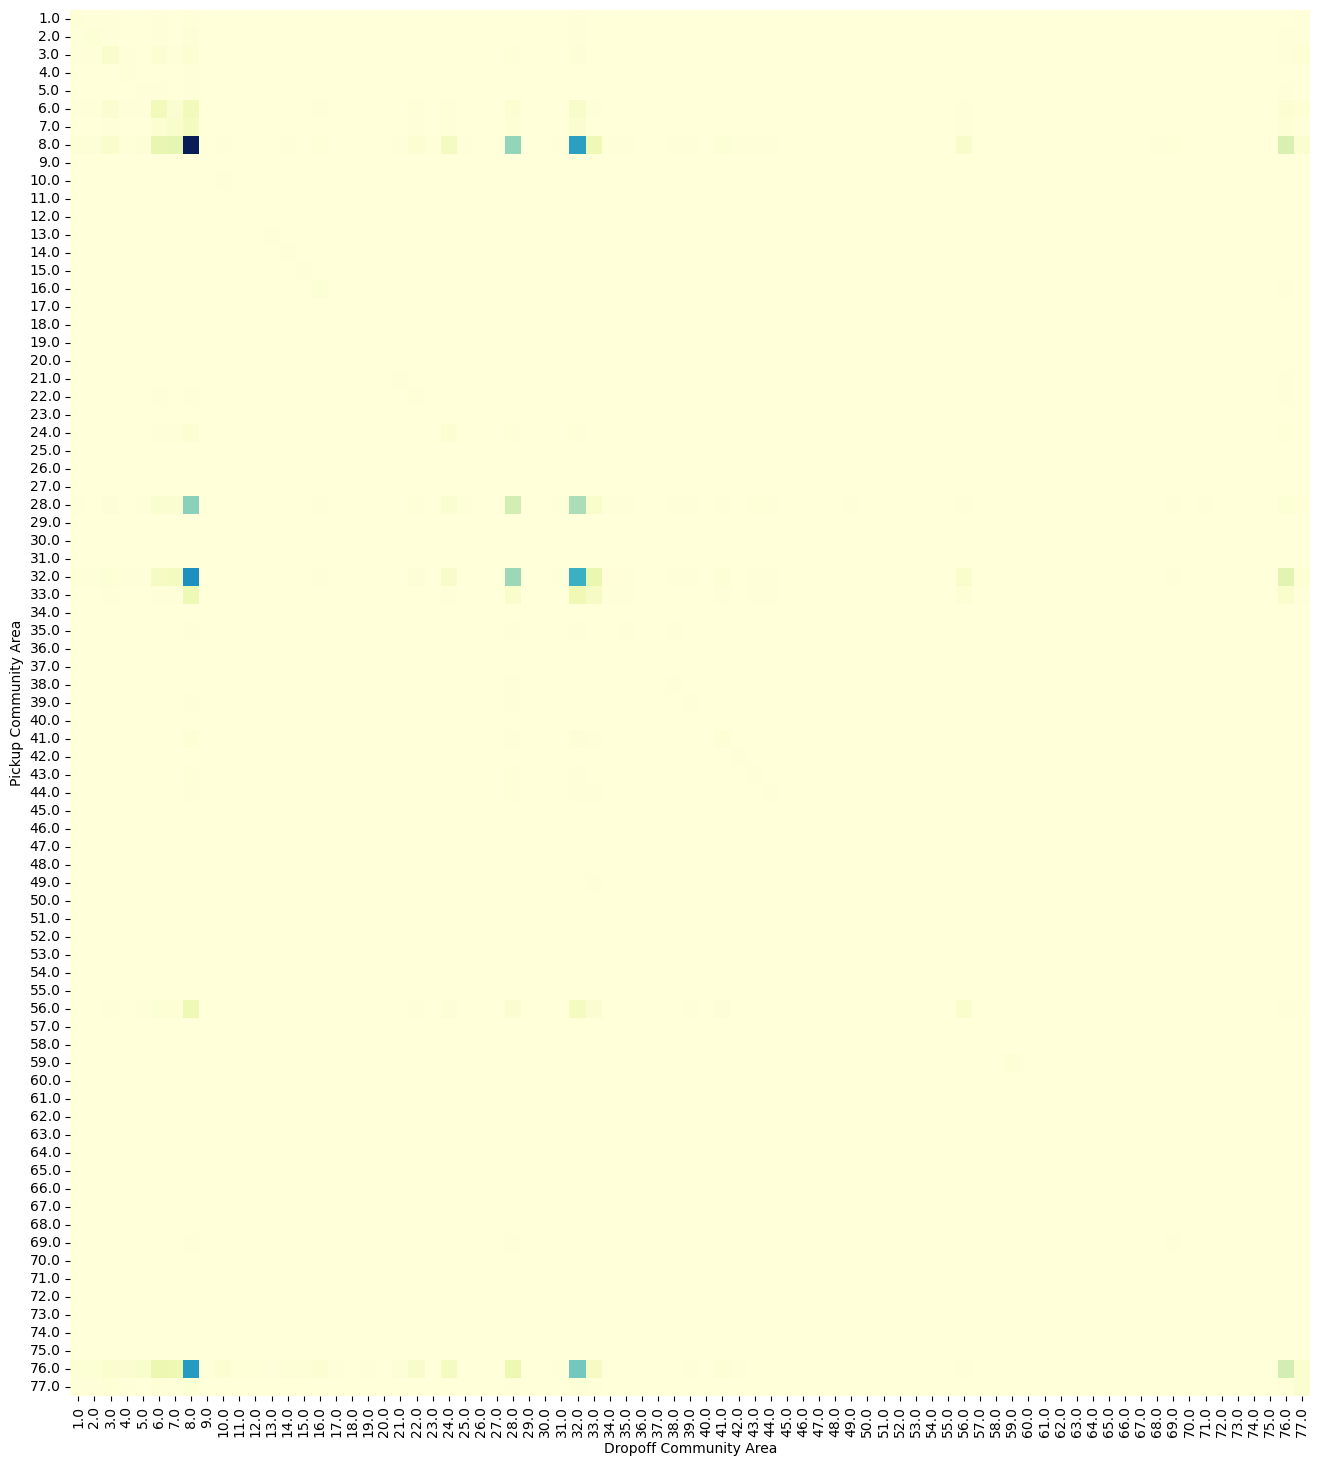

In [193]:
plt.figure(figsize = (16,18))
ax = sns.heatmap(pd.crosstab(trip['Pickup Community Area'], trip['Dropoff Community Area']), cmap='YlGnBu', annot=False, fmt='d', cbar=False)

8, 31 and 32 etc. are areas in downtown https://en.wikipedia.org/wiki/Community_areas_in_Chicago